# [EXPLORATION-08] 폐렴 진단 모델

# 1. Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore') 

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# BATCH_SIZE 변수
BATCH_SIZE = 64

# EPOCH 크기 변수
EPOCHS = 25

# 2. 데이터 준비

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(f'train 개수: {len(train_filenames)}')
print(f'validation 개수 : {len(val_filenames)}')
print(f'test 개수 : {len(test_filenames)}')

train 개수: 5216
validation 개수 : 16
test 개수 : 624


### train, val 데이터 조정
* val 개수가 너무 적기 때문에 train 과 val 에 있는 데이터를 모은 다음에 8:2 로 분할.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(f'train 개수: {len(train_filenames)}')
print(f'validation 개수 : {len(val_filenames)}')
print(f'test 개수 : {len(test_filenames)}')

train 개수: 4185
validation 개수 : 1047
test 개수 : 624


In [5]:
# 정상 이미지와 폐렴 이미지를 구분 파일 경로
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[1000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person3_bacteria_12.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person585_bacteria_2416.jpeg


### 정상과 폐렴 이미지 수 확인
* 데이터가 클래스 불균형(imbalance)을 이룸

In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1057
Pneumonia images count in training set: 3128


### tf.data 인스턴스 생성

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 라벨 데이터 생성

In [9]:
# label data 생성
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
# 이미지 데이터 타입 float로 변경 후 resize
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train, val dataset 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 이미지 확인
for image, label in train_ds.take(1): # take(1) 하나의 데이터만 가져오기
    print("Image shape: ", image.numpy().shape) # (180, 180, 3)
    print("Label: ", label.numpy()) # True

# testset 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT) # 624

Image shape:  (180, 180, 3)
Label:  True
624


`prepare_for_training()` : 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시킨다.

* `shuffle()` :고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
* `repeat()` : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용
* `batch()` : BATCH_SIZE에서 정한 만큼의 배치로 주어짐
* `prefetch()` : 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음

In [12]:
# tf.data 파이프라인 사용
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

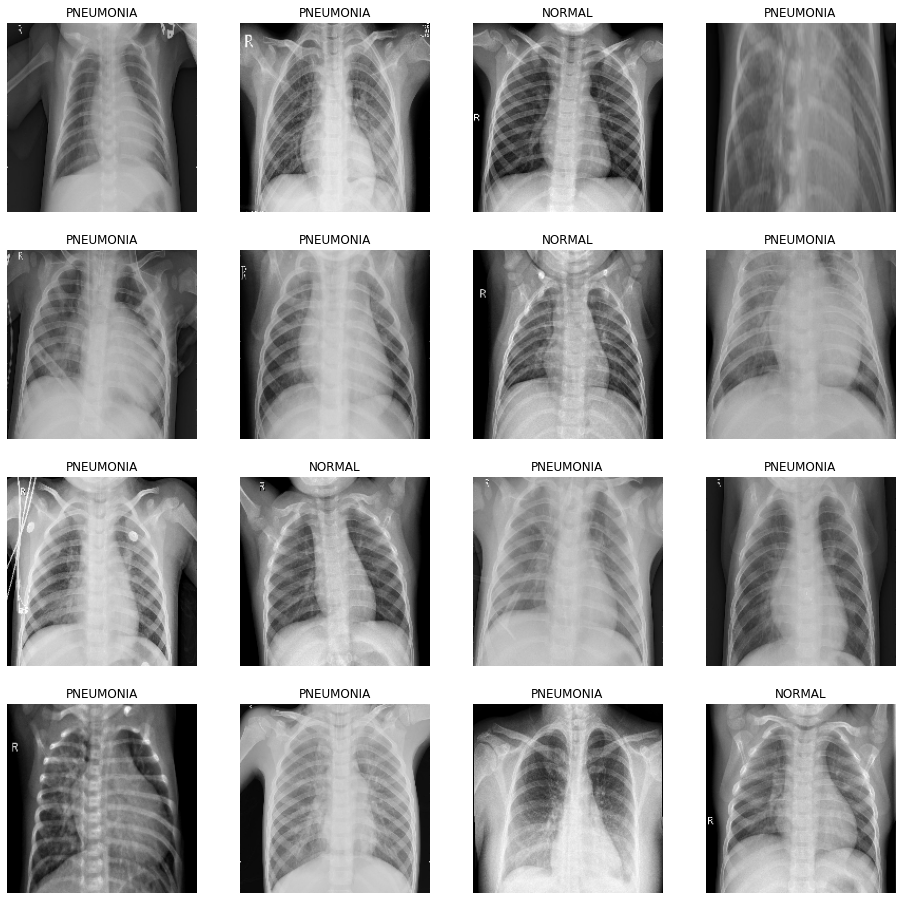

In [13]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,16))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

In [14]:
# Conv Layer
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [15]:
# Dense Layer
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

In [17]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0)) # 1.94
print('Weight for class 1: {:.2f}'.format(weight_for_1)) # 0.67

Weight for class 0: 1.98
Weight for class 1: 0.67


# 6. 모델 훈련

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 76s 373ms/step - loss: 0.3896 - accuracy: 0.8156 - precision: 0.9547 - recall: 0.7899 - val_loss: 0.6026 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 47s 367ms/step - loss: 0.2017 - accuracy: 0.9221 - precision: 0.9773 - recall: 0.9167 - val_loss: 0.8567 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 47s 366ms/step - loss: 0.1501 - accuracy: 0.9486 - precision: 0.9846 - recall: 0.9459 - val_loss: 1.1991 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 50s 385ms/step - loss: 0.1477 - accuracy: 0.9450 - precision: 0.9822 - recall: 0.9433 - val_loss: 1.6937 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 51s 395ms/step - loss: 0.1176 - accura

# 7. 결과 확인 및 시각화

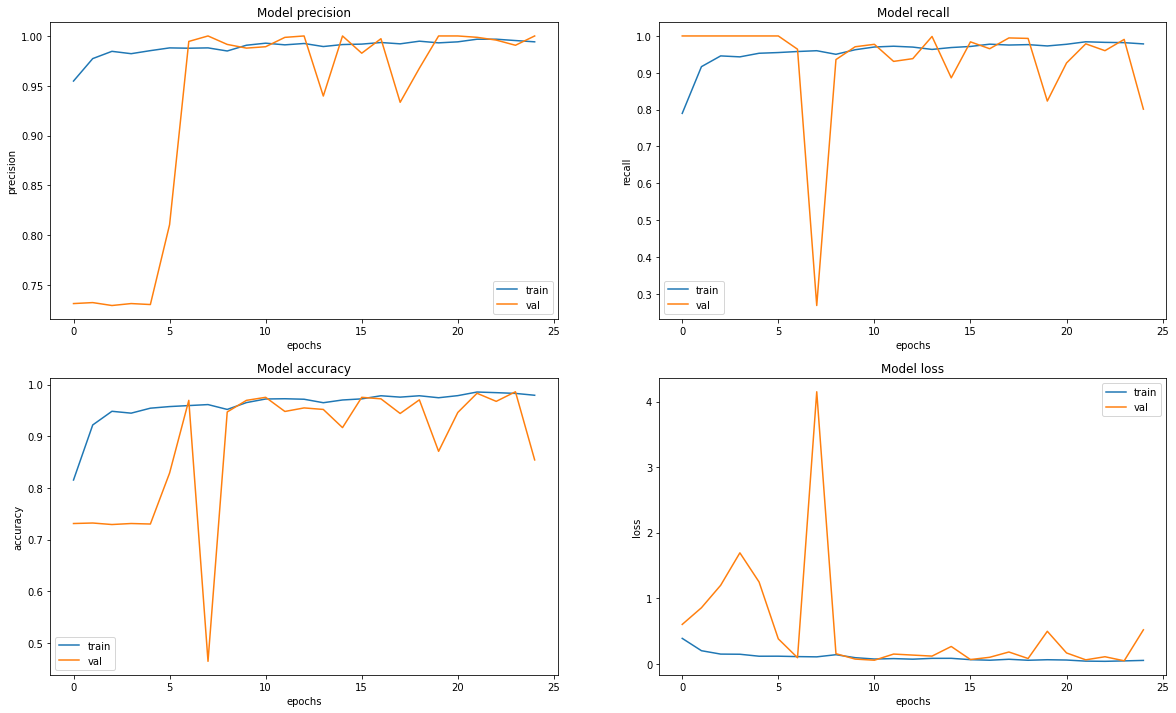

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 221ms/step - loss: 0.5217 - accuracy: 0.8510 - precision: 0.8857 - recall: 0.8744
Loss: 0.5216994285583496,
Accuracy: 0.8509615659713745,
Precision: 0.8857142925262451,
Recall: 0.8743589520454407


# Augmentation기법 사용

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),  # 좌우 반전
])

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        data_augmentation,  # 데이터 증강 레이어
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [62]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [63]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 79s 373ms/step - loss: 0.4148 - accuracy: 0.8024 - precision: 0.9479 - recall: 0.7770 - val_loss: 0.6219 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 371ms/step - loss: 0.2175 - accuracy: 0.9156 - precision: 0.9738 - recall: 0.9113 - val_loss: 0.8635 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 48s 374ms/step - loss: 0.1766 - accuracy: 0.9327 - precision: 0.9788 - recall: 0.9294 - val_loss: 1.0912 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 50s 387ms/step - loss: 0.1732 - accuracy: 0.9411 - precision: 0.9811 - recall: 0.9391 - val_loss: 1.2319 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 52s 405ms/step - loss: 0.1480 - accura

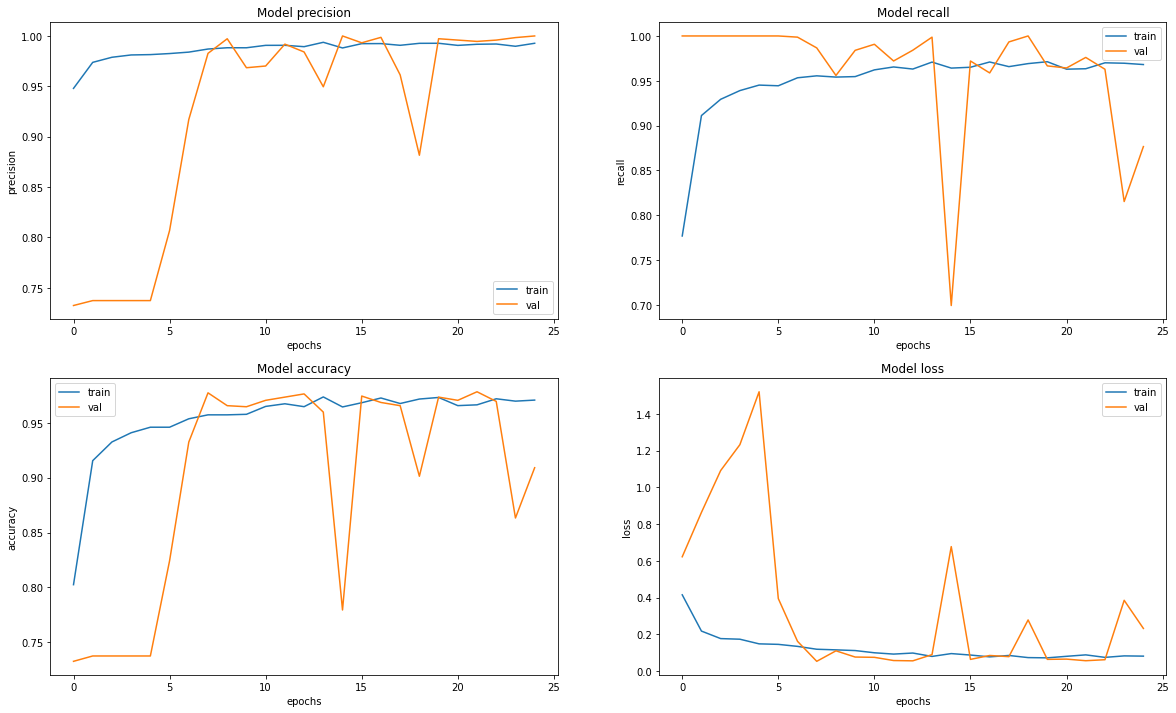

In [64]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [65]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 212ms/step - loss: 0.5146 - accuracy: 0.8590 - precision: 0.8612 - recall: 0.9231
Loss: 0.5145668387413025,
Accuracy: 0.8589743375778198,
Precision: 0.8612440228462219,
Recall: 0.9230769276618958


# Augmentation기법 사용 + BatchSize 64

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
65/65 [==============================] - 80s 767ms/step - loss: 0.4159 - accuracy: 0.8019 - precision: 0.9496 - recall: 0.7761 - val_loss: 0.5941 - val_accuracy: 0.7207 - val_precision: 0.7207 - val_recall: 1.0000
Epoch 2/25
65/65 [==============================] - 49s 763ms/step - loss: 0.2169 - accuracy: 0.9195 - precision: 0.9786 - recall: 0.9122 - val_loss: 0.7683 - val_accuracy: 0.7197 - val_precision: 0.7197 - val_recall: 1.0000
Epoch 3/25
65/65 [==============================] - 50s 784ms/step - loss: 0.1701 - accuracy: 0.9413 - precision: 0.9812 - recall: 0.9397 - val_loss: 0.9369 - val_accuracy: 0.7227 - val_precision: 0.7227 - val_recall: 1.0000
Epoch 4/25
65/65 [==============================] - 53s 818ms/step - loss: 0.1522 - accuracy: 0.9466 - precision: 0.9820 - recall: 0.9460 - val_loss: 1.0367 - val_accuracy: 0.7236 - val_precision: 0.7236 - val_recall: 1.0000
Epoch 5/25
65/65 [==============================] - 46s 709ms/step - loss: 0.1300 - accuracy: 0.9563

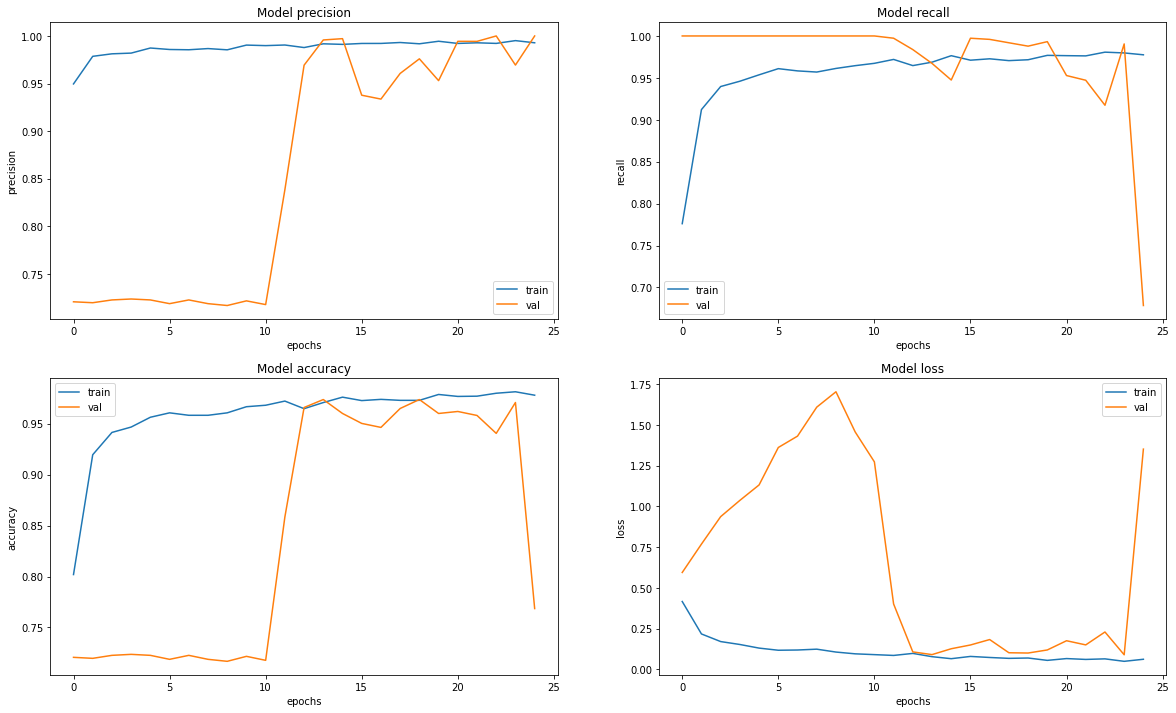

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 5s 468ms/step - loss: 0.8280 - accuracy: 0.8269 - precision: 0.9462 - recall: 0.7667
Loss: 0.828027069568634,
Accuracy: 0.8269230723381042,
Precision: 0.9462025165557861,
Recall: 0.7666666507720947


# 8. 프로젝트 정리

* 노드에서 학습한 내용만으로도 이미 충분히 높은 정확도를 보여주었기 때문에 별 다른 Tuning을 하지 않아도 Lubric을 만족하였다. 그러나 정확도를 더 높여보고자 여러가지 방법을 시도해보았다.


* BATCH_SIZE=32, dropout 적용 : loss: 0.5217, accuracy: 0.8510, precision: 0.8857, recall: 0.8744
* BATCH_SIZE=32, dropout 적용, 좌우 반전 augmentation 적용 : loss: 0.5146, accuracy: **0.8590**, precision: 0.8612, recall: 0.9231
* BATCH_SIZE=64, dropout 적용, 좌우 반전 augmentation 적용 : loss: 0.8280, accuracy: 0.8269, precision: 0.9462, recall: 0.7667